Pima indians diabetes analysis
============================

In [1]:
# Numerical libs
import numpy as np
import pandas as pd
# Definindo os algarismos significativos a serem apresentados nas tabelas.
pd.options.display.float_format = '{:.3f}'.format  

# Plot libs 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.rc('font',size=14)

## 1. Loading data file

In [2]:
dataset = pd.read_csv('pima-indians-diabetes.csv', header=None)

The variable names for the columns are as follows:

* 0. Number of times pregnant
* 1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* 2. Diastolic blood pressure (mm Hg)
* 3. Triceps skin fold thickness (mm)
* 4. 2-Hour serum insulin (mu U/ml)
* 5. Body mass index (weight in kg/(height in m)^2)
* 6. Diabetes pedigree function
* 7. Age (years)
* 8. Class variable: diabetes - not sick or sick (0 or 1)

In [11]:
dataset.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


Let's put a label on each column so we can easily remember their meaning.

In [12]:
# Alterando o nome das colunas
names = ['pregnancies', 'glucose', 'diastolic', 'triceps', 'insulin', 'bmi', 'dpf', 'age', 'diabetes']
dataset.columns = names
dataset.sample(10)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
628,5,128,80,0,0,34.600,0.144,45,0
671,1,99,58,10,0,25.400,0.551,21,0
509,8,120,78,0,0,25.000,0.409,64,0
229,0,117,80,31,53,45.200,0.089,24,0
506,0,180,90,26,90,36.500,0.314,35,1
714,3,102,74,0,0,29.500,0.121,32,0
613,6,105,80,28,0,32.500,0.878,26,0
410,6,102,90,39,0,35.700,0.674,28,0
559,11,85,74,0,0,30.100,0.300,35,0
420,1,119,88,41,170,45.300,0.507,26,0


## 2. Exploratory Data Analysis (EDA)

In [13]:
# Checking the size of dataframe
print("Dataset size: ",dataset.shape)

Dataset size:  (768, 9)


Right at the begining of the table, we could notice "NaN" values in some columns.

`.info` tell us the total number of non null observations present including the total number of entries. Once number of entries isn’t equal to number of non null observations, we can begin to suspect missing values.

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnancies    768 non-null int64
glucose        768 non-null int64
diastolic      768 non-null int64
triceps        768 non-null int64
insulin        768 non-null int64
bmi            768 non-null float64
dpf            768 non-null float64
age            768 non-null int64
diabetes       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can then count the number of NaN in each column with `.sum()` after `.isnull()` identify a null entry.

In [10]:
dataset.isnull().sum().sort_values(ascending = False)

diabetes       0
age            0
dpf            0
bmi            0
insulin        0
triceps        0
diastolic      0
glucose        0
pregnancies    0
dtype: int64

`.describe()` will display a summary statistics of all observed features and labels. The most important to note here is the min value. Once we see -1/0 in an observation like age/height/weight/bmi, then we have been able to detect missing value.

In [7]:
dataset.describe()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
count,768.00,763.00,733.00,541.00,394.00,768.00,768.00,768.00,768.00
mean,3.85,121.69,72.41,29.15,155.55,31.99,0.47,33.24,0.35
std,3.37,30.54,12.38,10.48,118.78,7.88,0.33,11.76,0.48
min,0.00,44.00,24.00,7.00,14.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,64.00,22.00,76.25,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,29.00,125.00,32.00,0.37,29.00,0.00
75%,6.00,141.00,80.00,36.00,190.00,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


We can see that columns 1 to 4 have a Nan (Not a Number). On column 5, a value of zero does not make sense and indicates an invalid or missing value.

In [8]:
(dataset[['bmi']] == 0).sum()

bmi    11
dtype: int64

The following columns have an invalid value:

1: Plasma glucose concentration; 2: Diastolic blood pressure; 3: Triceps skinfold thickness; 4: 2-Hour serum insulin; 5: Body mass index


It is important to know the percentage of missing values for each column, so we can verify if the column can be discarded or not. 

In [9]:
data_size = dataset.shape # get the dataframe's shape 
data_nan = dataset.isnull().sum() 
data_zero = (dataset[['bmi']] == 0).sum()
data_nan['bmi'] = data_zero['bmi']
data_nan = data_nan / data_size[0]*100 
data_nan

pregnancies    0.00
glucose        0.65
diastolic      4.56
triceps       29.56
insulin       48.70
bmi            1.43
dpf            0.00
age            0.00
diabetes       0.00
dtype: float64

If missing values for each column reach percentage close to 90%,  the information will surely not help us to classify the data, therefore the entire column can be removed.
On the other hand, when few rows have missing values, less than 0.5% (as a rule of thumb), those rows can be disregarded.

## 3. Treating missing values

Some classifiers can not handle missing values, therefore, we need a way to treat the missing values.



* Strategy:
  1. Analisar o numero de dados se removidas todas as linhas com NaN
  2. Comparar os histogramas dos dados com e sem NaN

* `bmi` tem 1.43% de seus dados incompletos, assim como `glucose` com 0.65% --> as linhas podem ser removidas.
* 

### Target analysis:

To check the fraction of people sick or healthy in data set.

In [10]:
n_health, n_sick = np.array([(dataset[['diabetes']] == 0).sum(), (dataset[['diabetes']] == 1).sum()]) / data_size[0] * 100

In [11]:
print('Percentage of healthy is {:.2f}% and {:.2f}% are sick.'.format(n_health[0],n_sick[0]))

Percentage of healthy is 65.10% and 34.90% are sick.


### Pearson correlation: 

In [12]:
dataset.corr()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
pregnancies,1.00,0.13,0.21,0.10,0.08,0.02,-0.03,0.54,0.22
glucose,0.13,1.00,0.22,0.23,0.58,0.24,0.14,0.27,0.49
diastolic,0.21,0.22,1.00,0.23,0.10,0.26,-0.00,0.33,0.17
triceps,0.10,0.23,0.23,1.00,0.18,0.63,0.12,0.17,0.26
insulin,0.08,0.58,0.10,0.18,1.00,0.23,0.13,0.22,0.30
bmi,0.02,0.24,0.26,0.63,0.23,1.00,0.14,0.04,0.29
dpf,-0.03,0.14,-0.00,0.12,0.13,0.14,1.00,0.03,0.17
age,0.54,0.27,0.33,0.17,0.22,0.04,0.03,1.00,0.24
diabetes,0.22,0.49,0.17,0.26,0.30,0.29,0.17,0.24,1.00


## 4. Getting insights from data

## Graphics:

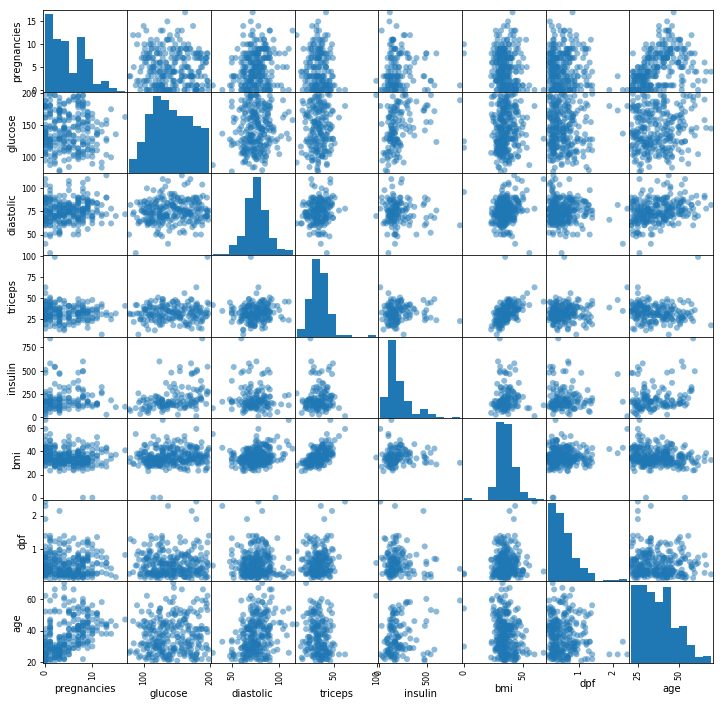

In [13]:
df_ptos = dataset[dataset['diabetes'] == 1].loc[:,['pregnancies', 'glucose', 'diastolic', 
                                                   'triceps', 'insulin', 'bmi', 'dpf', 'age']]
pd.plotting.scatter_matrix(df_ptos, figsize=(12,12), marker='o');

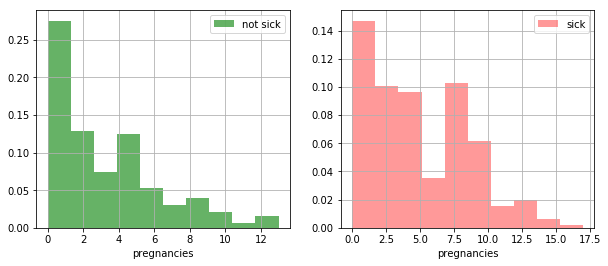

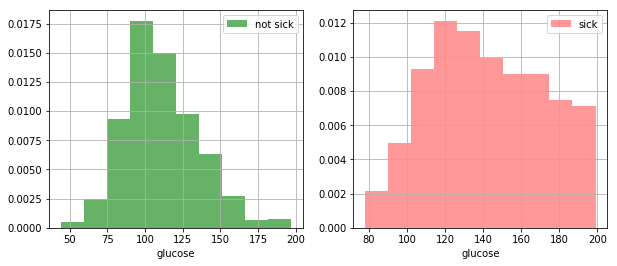

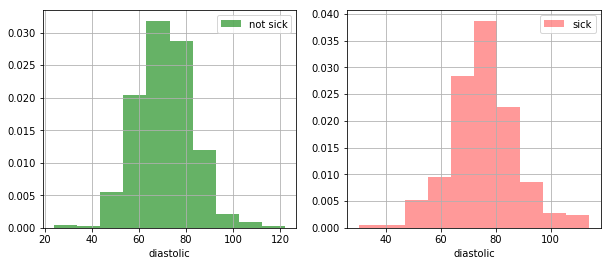

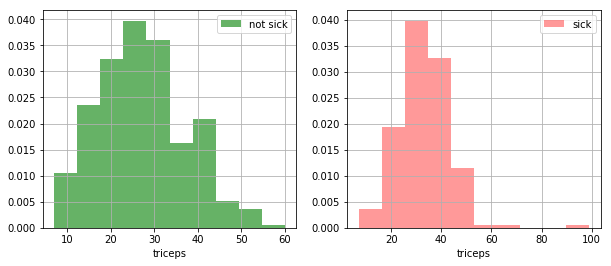

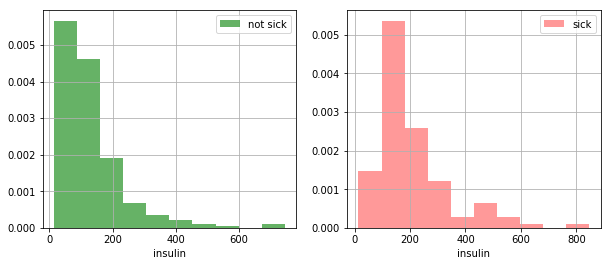

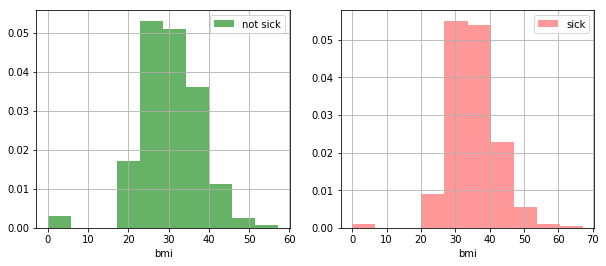

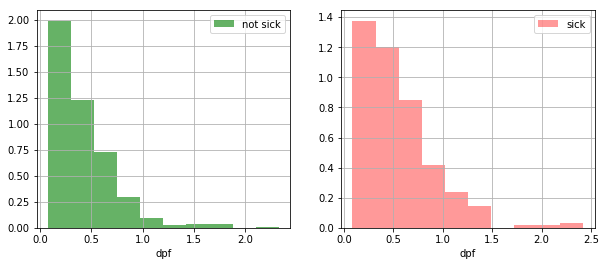

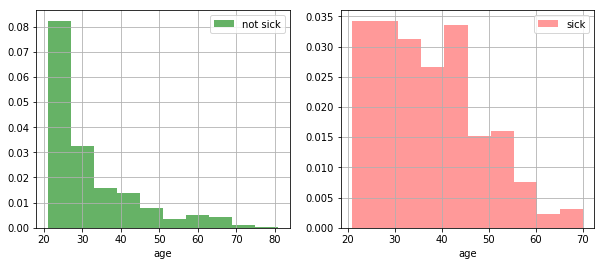

In [14]:
for key in dataset.columns[:-1]:
    plt.figure(figsize=(10,4))
    not_sick = dataset[dataset['diabetes'] == 0][key].reset_index(drop = True)
    sick     = dataset[dataset['diabetes'] == 1][key].reset_index(drop = True)
    plt.subplot(1,2,1)
    not_sick.hist(alpha = 0.6, color = 'green', label = 'not sick', density=True)
    plt.xlabel(key)
    plt.legend(framealpha = 0.8);
    plt.subplot(1,2,2)
    sick.hist(alpha = 0.4, color = 'red', label = 'sick', density=True)
    plt.xlabel(key)
    plt.legend(framealpha = 0.8);
    plt.show()